In [4]:
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/plotting.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/disturbances.jl")
include("../scripts/ps_analysis.jl");
using FFTW
using LinearAlgebra
using Statistics

In [5]:
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.01
mesh = get_grid(border, dx); # renamed to be able to use the grid function for plotting

In [6]:
# compute or load grid parameters
contmod = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-6);

  1.998467 seconds (3.77 M allocations: 4.683 GiB, 7.06% gc time, 17.36% compilation time)
  2.323667 seconds (4.27 M allocations: 500.365 MiB, 16.99% gc time, 76.93% compilation time)


In [7]:
# create the list of edges
# the following is incomplete but should be sufficient
epsilon = Int64.(zeros(4*contmod.Nx*contmod.Ny, 2))
l = 1

for k in 1:contmod.Nx*contmod.Ny
    if(contmod.isinside[k])
        epsilon[l,:] = [k k+contmod.Ny]
        epsilon[l+1,:] = [k k+1]
        l +=2
    end
end

for id in 1:size(contmod.n,1)
    k = (Int64(contmod.n[id, 2]) - 1) * contmod.Ny + Int64(contmod.n[id, 1])
    ny = contmod.n[id, 3]
    nx = contmod.n[id, 4]
    if(nx == 0)
        epsilon[l,:] = [k k+contmod.Ny]
        #epsilon[l+1,:] = [k k-contmod.Ny]
        #l +=2
        l +=1
    elseif(nx == -1)
        epsilon[l,:] = [k k+contmod.Ny]
        l +=1
    elseif(nx == 1)
        #epsilon[l,:] = [k k-contmod.Ny]
        #l +=1
    end
    if(ny == 0)
        epsilon[l,:] = [k k+1]
        #epsilon[l+1,:] = [k k-1]
        l +=1
    elseif(ny == -1)
        epsilon[l,:] = [k k+1]
        l +=1
    elseif(ny == 1)
        #epsilon[l,:] = [k k-1]
        #l +=1
    end
end

epsilon = epsilon[1:l-1,:]

epsilon_new = Int64.(zeros(size(epsilon)))
id = findall(contmod.isgrid)
n = length(id)
#id = findall(contmod.isborder)
#println(id)
for i = 1:length(id)
    id1 = (epsilon[:,1] .== id[i])
    id2 = (epsilon[:,2] .== id[i])
    epsilon_new[id1,1] .= i
    epsilon_new[id2,2] .= i
end

grid_coord = contmod.coord[contmod.isgrid, :];

In [8]:
# DONT DO THIS PLOT IF dx is smaller than ~0.05
if(dx >= 0.05)
    plot(aspect_ratio=:equal, legend=false)
    for k = 1:size(epsilon_new,1)
        if(epsilon_new[k,1] != 0 && epsilon_new[k,2] != 0)
            #println(coord[[epsilon_new[k,1] epsilon_new[k,2]],2],)
            plot!(vec(grid_coord[[epsilon_new[k,1] epsilon_new[k,2]],2]),
                vec(grid_coord[[epsilon_new[k,1] epsilon_new[k,2]],1]),color=:black)
        end
    end
    scatter!(contmod.coord[contmod.isgrid,2], contmod.coord[contmod.isgrid,1])

    current()
end


In [9]:
N = size(epsilon_new,1)
id1 = [epsilon_new[:,1];epsilon_new[:,2]]
id2 = vec([1:N 1:N])
v = [-ones(N); ones(N)]
B = sparse(id1, id2, v)
L = B*B'
Lfull = Array{Float64,2}(L)
res = eigen(Lfull);

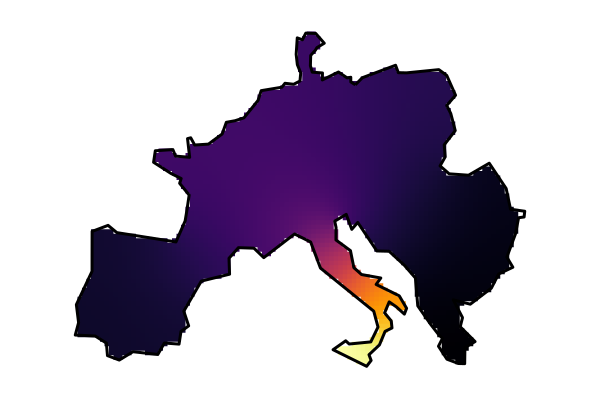

In [10]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = vec(res.vectors[:,3])
hm_plot(contmod, temp; borders=[border])

In [68]:
# perform Lanczos Algorithm

v = rand(n,1)
v = v .- mean(v)
v = v / norm(v)

w =  L * v
alpha = dot(w, v)
w = w - alpha * v

V = v
as = alpha
bs = []

Ncut = 300

for i=2:Ncut
    beta = norm(w)
    if(beta > 1E-6)
        v = w / beta
    else
        println("CAWABUNGA")
        v = rand(n, 1)
        for j=1:i-1
            v -= dot(v, V[:,j]) * V[:,j]
        end
        v  /= norm(v)
    end

    w = L * v
    alpha = dot(w, v)
    w = w - alpha * v - beta * V[:,i-1]
    bs = [bs; beta]
    as = [as alpha]
    V = [V v]
end



T = zeros(Ncut, Ncut)
for i=1:Ncut
    T[i,i] = as[i]
end
for i=1:Ncut-1
    T[i, i+1] = bs[i]
    T[i+1, i] = bs[i]
end


res2 = eigen(T)
VV = V * res2.vectors;
VV = [VV ones(n)/sqrt(n)]; # add the lambda=0 mode

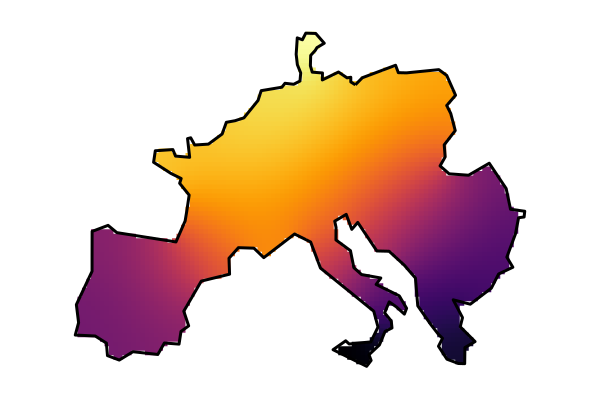

In [69]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = vec(VV[:,3])
hm_plot(contmod, temp; borders=[border])

In [74]:
# project the quantities over the modes
mred = zeros(size(contmod.m))
dred = zeros(size(contmod.d))
pred = zeros(size(contmod.p))
bxred = zeros(size(contmod.bx))
byred = zeros(size(contmod.by))
for i = 1:Ncut+1
    mred[contmod.isgrid] += dot(contmod.m[contmod.isgrid], vec(VV[:,i])) * vec(VV[:,i])
    dred[contmod.isgrid] += dot(contmod.d[contmod.isgrid], vec(VV[:,i])) * vec(VV[:,i])
    bxred[contmod.isgrid] += dot(contmod.bx[contmod.isgrid], vec(VV[:,i])) * vec(VV[:,i])
    byred[contmod.isgrid] += dot(contmod.by[contmod.isgrid], vec(VV[:,i])) * vec(VV[:,i])
    temp = zeros(size(contmod.p))
    temp[contmod.isgrid] = vec(VV[:,i])
    pred = zeros(size(contmod.p))
end

LoadError: BoundsError: attempt to access 3854-element Vector{Float64} at index [Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

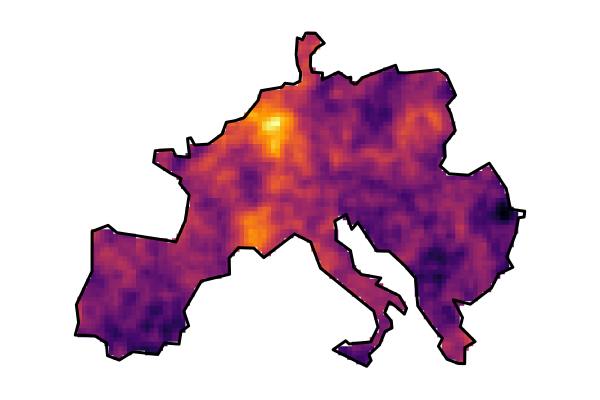

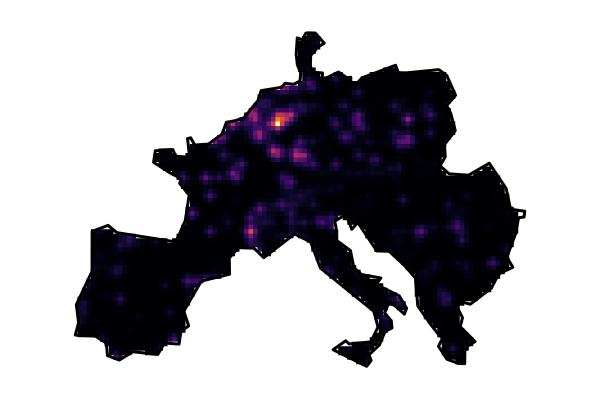

In [73]:
hm_plot(contmod, contmod.m; borders=[border])